## 1.Importing Packages

In [1]:
import re
import os
import random
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
# import mlflow
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential,Model, load_model

from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

## 2.Loading Data

In [2]:
DATA_PATH = "/content/drive/MyDrive/Data Science/NLP Problems/04_Text_Classification/BBC News Classification/dataset"

In [3]:
df = pd.read_csv(os.path.join(DATA_PATH, "train_clean_data.csv"),
                 usecols = ['clean_text', 'Label'])
df.head()

,clean_text,Label
0,worldcom ex boss launches defence lawyers defe...,0
1,german business confidence slides german busin...,0
2,bbc poll indicates economic gloom citizens maj...,0
3,lifestyle governs mobile choice faster better ...,1
4,enron bosses payout eighteen former enron dire...,0


## 3.Train-Test Split

In [4]:
X = df.drop(['Label'], axis=1)
Y = df[['Label']]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, stratify=Y, random_state=42)
print('Train Data Shape: ', (X_train.shape, y_train.shape))
print('Test Data Shape: ', (X_test.shape, y_test.shape))

Train Data Shape:  ((1192, 1), (1192, 1))
Test Data Shape:  ((298, 1), (298, 1))


## 4.Utility function

In [5]:
# This function visualizes train acc, test acc, train loss, test loss after n epochs of training
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

## 5.MLP without pre-trained embeddings

### 5.1 Data Preparation

In [ ]:
# Encoding each word in text with unique integer
start = datetime.now()
vocab_size = 1000
encoded_train = [one_hot(X_train.iloc[i, 0], vocab_size) for i in range(len(X_train))]
encoded_test = [one_hot(X_test.iloc[i, 0], vocab_size) for i in range(len(X_test))]
print("Time taken: ", datetime.now() - start)

Time taken:  0:00:00.619653


In [ ]:
# No. of words in each comment
n_words = [len(i) for i in encoded_train]
for i in range(90, 100):
    print("{}th percentile: {}".format(i, np.percentile(n_words, i)))

90th percentile: 355.8000000000002
91th percentile: 362.80999999999995
92th percentile: 372.72
93th percentile: 382.2600000000002
94th percentile: 392.0799999999999
95th percentile: 408.0
96th percentile: 423.3599999999999
97th percentile: 445.53999999999996
98th percentile: 477.72000000000025
99th percentile: 567.0899999999999


**Note: 95% of sentences have words less that 400.**

In [ ]:
# Padding each sequence to have same length(400)
MAX_LENGTH = 1000
encoded_train = pad_sequences(encoded_train, maxlen=MAX_LENGTH, padding='post')
print("Train data shape: ", encoded_train.shape)
encoded_test = pad_sequences(encoded_test, maxlen=MAX_LENGTH, padding='post')
print("Test data shape: ", encoded_test.shape)

Train data shape:  (1192, 1000)
Test data shape:  (298, 1000)


### 5.2 Model Architecture

In [ ]:
clear_session()

input_layer = layers.Input(shape=(1000,)) # input

embed_layer = layers.Embedding(vocab_size, 1000, input_length=1000)(input_layer) # embedding
maxpool1 = layers.GlobalMaxPool1D()(embed_layer) # global pooling layer
dense1 = layers.Dense(100, activation='relu')(maxpool1) # hidden layer

output_layer = layers.Dense(5, activation='sigmoid')(dense1) # output layer

mlp_model = Model(input_layer, output_layer)
mlp_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 1000, 1000)          │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 1000)                │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │         100,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             505 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,100,605 (4.20 MB)

 Trainable params: 1,100,605 (4.20 MB)

 Non-trainable params: 0 (0.00 B)

### 5.3 Callbacks

In [ ]:
# Callback to save model
filepath = '/content/mlp_model/mlp_model.keras'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, mode='max', save_best_only=True)


In [ ]:
# Reduce learning rate by 10% if val acc didn't improve for 3 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, verbose=1)

In [ ]:
callback = [checkpoint, reduce_lr]

### 5.4 Model Training

In [ ]:
# compiling model
mlp_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# training model
history = mlp_model.fit(encoded_train, y_train, batch_size=64, epochs=10,
              validation_data=(encoded_test, y_test), callbacks=callback)

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/step - accuracy: 0.2683 - loss: 1.6034
Epoch 1: val_accuracy improved from -inf to 0.23154, saving model to /content/mlp_model/mlp_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 865ms/step - accuracy: 0.2700 - loss: 1.6027 - val_accuracy: 0.2315 - val_loss: 1.5580 - learning_rate: 0.0010
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 770ms/step - accuracy: 0.3582 - loss: 1.5345
Epoch 2: val_accuracy improved from 0.23154 to 0.54027, saving model to /content/mlp_model/mlp_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 827ms/step - accuracy: 0.3633 - loss: 1.5334 - val_accuracy: 0.5403 - val_loss: 1.4456 - learning_rate: 0.0010
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6381 - loss: 1.3632
Epoch 3: val_accuracy improved from 0.54027 to 0.77517, saving model to /content/mlp_model/mlp_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6424 - loss: 1.3601 - val_accuracy: 0.7752 - val_loss: 1.1675 - learning_rate: 0.0010
Epoc

### 5.5 Model Evaluation

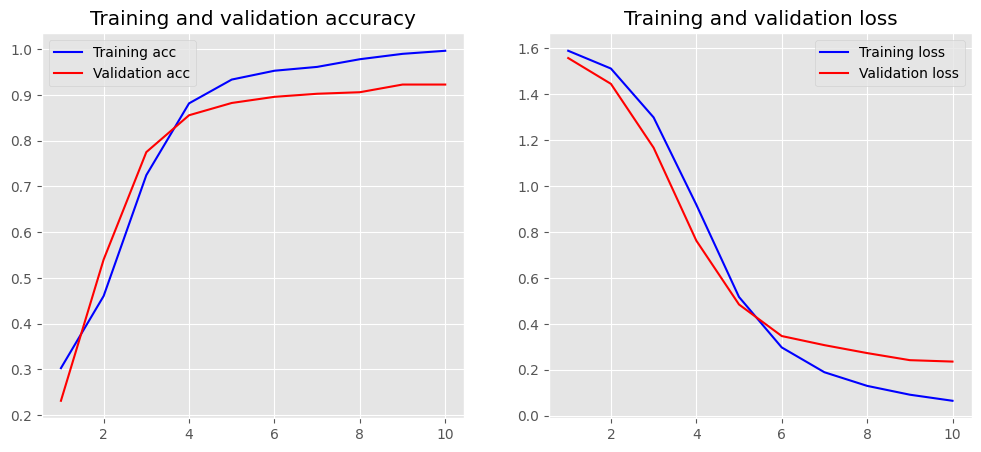

In [ ]:
# Plot history
plot_history(history)

In [ ]:
y_pred_train = mlp_model.predict(encoded_train, batch_size=64, verbose=1)
y_pred_bool_train = np.argmax(y_pred_train, axis=1)

print(classification_report(y_train, y_pred_bool_train, zero_division=1))

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       269
           1       1.00      1.00      1.00       209
           2       1.00      1.00      1.00       219
           3       1.00      1.00      1.00       277
           4       1.00      0.99      1.00       218

    accuracy                           1.00      1192
   macro avg       1.00      1.00      1.00      1192
weighted avg       1.00      1.00      1.00      1192



In [ ]:
y_pred_test = mlp_model.predict(encoded_test, batch_size=64, verbose=1)
y_pred_bool_test = np.argmax(y_pred_test, axis=1)

print(classification_report(y_test, y_pred_bool_test, zero_division=1))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        67
           1       0.90      0.85      0.87        52
           2       0.86      0.91      0.88        55
           3       0.97      1.00      0.99        69
           4       0.91      0.91      0.91        55

    accuracy                           0.92       298
   macro avg       0.92      0.92      0.92       298
weighted avg       0.92      0.92      0.92       298



#### **Obeservation:**

- without embeddings *92%* f1-score

## 6.MLP with Glove Embeddings

#### 6.0.1 Downloading Embeddings

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2025-01-01 11:18:53--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-01-01 11:18:53--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-01-01 11:18:54--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

#### 6.0.2 Unzipping Embeddings

In [ ]:
!unzip /content/glove.6B.zip

Archive:  /content/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


### 6.1 Tokenization and Padding


#### 6.1.1 Tokenization


In [6]:
# Tokenization
t = Tokenizer()
t.fit_on_texts(X_train['clean_text'])
tokens_train = t.texts_to_sequences(X_train['clean_text'])
tokens_test = t.texts_to_sequences(X_test['clean_text'])

In [7]:
print("Original Comment: ", X_train['clean_text'].iloc[0])
print("Tokenized Comment: ", tokens_train[0])

Original Comment:  bt program beat dialler scams bt introducing two initiatives help beat rogue dialler scams cost dial net users thousands may dial net users able download free software stop computers using numbers user pre approved list inadvertently downloaded surfers rogue diallers programs hijack modems dial premium rate number users log thousands uk dial users believed hit scam people faced phone bills bt modem protection program check numbers dialled computer block pre approved national net service provider numbers icstis uk premium rate services watchdog said looking companies take lead initiatives initiatives welcome spokesperson icstis told bbc news website pleased see putting place new measures protect consumers second initiative bt announced early warning system alert bt customers unusual activity phone bills bill rises substantially usual daily average call made suspect number text voice alert sent user landline phone part clamp rogue diallers companies must satisfy string

In [8]:
vocab_size = len(t.word_index) + 1 # adding one for reserve word, like words out of vocabulary
print("Total unique words: ", vocab_size)

Total unique words:  21533


In [ ]:
# Saving pickle file of tokenizer object
with open(os.path.join(DATA_PATH, "glove_embeddings", 'tokenizer.pkl'), 'wb') as f:
    pickle.dump(t, f)

#### 6.1.2 Padding sequences

Since 95% text have less than 400 words. Let's pad each sequence to have 400 words.

In [9]:
MAX_LENGTH = 400
padded_train = pad_sequences(tokens_train, maxlen=MAX_LENGTH, dtype='int32',
                        padding='post', truncating='post', value=0.0)
padded_test = pad_sequences(tokens_test, maxlen=MAX_LENGTH, dtype='int32',
                        padding='post', truncating='post', value=0.0)

In [10]:
padded_train.shape, padded_test.shape

((1192, 400), (298, 400))

### 6.3 Embedding

In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [24]:
embedding_dim = 300

In [ ]:
embedding_matrix = create_embedding_matrix('/content/glove.6B.300d.txt',
                                           t.word_index, embedding_dim)
embedding_matrix.shape

(21533, 300)

#### 6.3.1 Saving Embeddings

In [ ]:
# Saving 300-D embeddings, this is acting a look up table
with open(os.path.join(DATA_PATH, 'glove_embeddings', 'glove_embeddinga.npy'), 'wb') as f:
    np.save(f, embedding_matrix)

#### 6.3.2 Loading Embeddings

In [ ]:
# Loading 300-D embeddings, this is acting a look up table
embedding_matrix = np.load(os.path.join(DATA_PATH, 'glove_embeddings', 'glove_embeddinga.npy'))

#### 6.3.3 Proportion of non-zero embedding vectors

In [ ]:
# Proportion of non-zero embedding vectors
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.9742720475549157

97% words in vocabulary have been embedded with non-zero vectors using Glove pre-trained model.

### 6.3 Callbacks

In [ ]:
# Callback to save model
filepath = '/content/glove_model1/glove_model.keras'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuarcy', verbose=1, mode='max', save_best_only=True)

In [ ]:
# Reduce learning rate by 10% if val acc didn't improve for 3 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_accuarcy', factor=0.1, patience=3, verbose=1)

In [ ]:
callback = [checkpoint, reduce_lr]

### 6.4 Model Training

In [ ]:
clear_session()

input_layer = layers.Input(shape=(400,))

embed_layer = layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                              input_length=400, trainable=False)(input_layer)

maxpool1 = layers.GlobalMaxPool1D()(embed_layer)

dense1 = layers.Dense(256, activation='relu')(maxpool1)
drop1 = layers.Dropout(0.2)(dense1)
dense2 = layers.Dense(128, activation='relu')(drop1)
drop2 = layers.Dropout(0.2)(dense2)
dense3 = layers.Dense(64, activation='relu')(drop2)
output_layer = layers.Dense(5, activation='sigmoid')(dense3)
glove_model = Model(input_layer, output_layer)
glove_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 400, 300)            │       6,459,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 300)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          77,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,578,433 (25.09 MB)

 Trainable params: 118,533 (463.02 KB)

 Non-trainable params: 6,459,900 (24.64 MB)

In [ ]:
# compiling model
glove_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# training model
history = glove_model.fit(padded_train, y_train, batch_size=64, epochs=15,  validation_data=(padded_test, y_test), callbacks=callback)

Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.2362 - loss: 1.6999 - val_accuracy: 0.3087 - val_loss: 1.5404 - learning_rate: 0.0010
Epoch 2/15
 1/19 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.1875 - loss: 1.6090

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuarcy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_accuarcy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.2384 - loss: 1.5873 - val_accuracy: 0.4698 - val_loss: 1.4444 - learning_rate: 0.0010
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3981 - loss: 1.4490 - val_accuracy: 0.6443 - val_loss: 1.2174 - learning_rate: 0.0010
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5118 - loss: 1.2643 - val_accuracy: 0.5940 - val_loss: 1.0412 - learning_rate: 0.0010
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6154 - loss: 1.0534 - val_accuracy: 0.7550 - val_loss: 0.8398 - learning_rate: 0.0010
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6994 - loss: 0.8910 - val_accuracy: 0.7047 - val_loss: 0.6902 - learning_rate: 0.0010
Epoch 7/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7598 - loss: 0.6683 - val_accuracy: 0.8557 - val_loss: 0.4956 - learning_rate: 0.0010
Epoch 8/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8314 - loss: 0.5196 - val_accuracy: 0.87

### 6.5 Evaluation

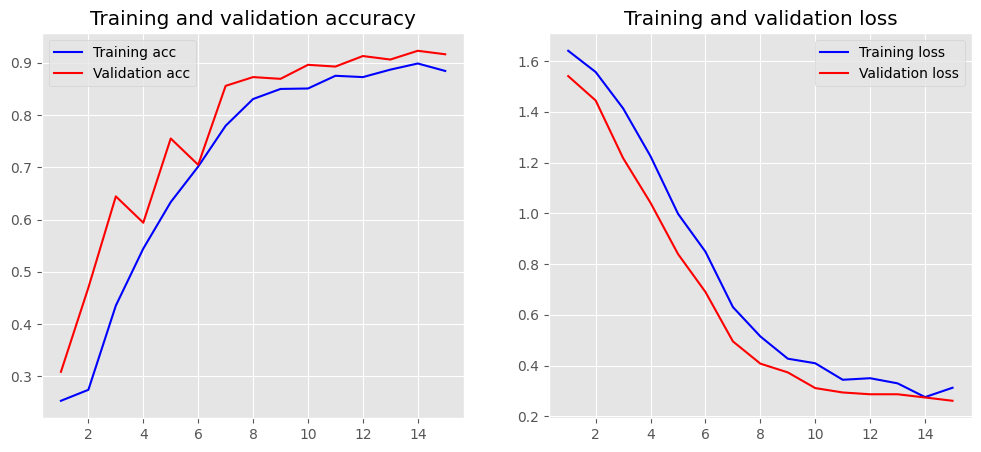

In [ ]:
# Plot history
plot_history(history)

In [ ]:
y_pred_train = glove_model.predict(padded_train, batch_size=64, verbose=1)
y_pred_bool_train = np.argmax(y_pred_train, axis=1)

print(classification_report(y_train, y_pred_bool_train, zero_division=1))

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       269
           1       0.00      0.00      0.00       209
           2       1.00      0.00      0.00       219
           3       0.29      0.67      0.41       277
           4       0.14      0.34      0.19       218

    accuracy                           0.22      1192
   macro avg       0.49      0.20      0.12      1192
weighted avg       0.50      0.22      0.13      1192



In [ ]:
y_pred_test = glove_model.predict(padded_test, batch_size=64, verbose=1)
y_pred_bool_test = np.argmax(y_pred_test, axis=1)

print(classification_report(y_test, y_pred_bool_test, zero_division=1))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
              precision    recall  f1-score   support

           0       1.00      0.00      0.00        67
           1       0.33      0.04      0.07        52
           2       0.00      0.00      0.00        55
           3       0.30      0.62      0.41        69
           4       0.11      0.31      0.17        55

    accuracy                           0.21       298
   macro avg       0.35      0.19      0.13       298
weighted avg       0.37      0.21      0.14       298



#### **Obeservation:**

- without training GloVe embeddings **14%** f1-score, worst performance

## 7.Training Glove Embeddings

### 7.1 Callbacks

In [ ]:
# Callback to save model
filepath = '/content/glove_model2/glove_model2.keras'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuarcy', verbose=1, mode='max', save_best_only=True)

# Reduce learning rate by 10% if val acc didn't improve for 3 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_accuarcy', factor=0.1, patience=3, verbose=1)

callback = [checkpoint, reduce_lr]

### 7.2 Model Training

In [ ]:
clear_session()

input_layer = layers.Input(shape=(400,))

embed_layer = layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                              input_length=400, trainable=True)(input_layer)

maxpool1 = layers.GlobalMaxPool1D()(embed_layer)

dense1 = layers.Dense(256, activation='relu')(maxpool1)
drop1 = layers.Dropout(0.2)(dense1)
dense2 = layers.Dense(128, activation='relu')(drop1)
drop2 = layers.Dropout(0.2)(dense2)
dense3 = layers.Dense(64, activation='relu')(drop2)
output_layer = layers.Dense(5, activation='sigmoid')(dense3)
glove_model = Model(input_layer, output_layer)
glove_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 400, 300)            │       6,459,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 300)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          77,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,578,433 (25.09 MB)

 Trainable params: 6,578,433 (25.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# compiling model
glove_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# training model
history = glove_model.fit(padded_train, y_train, batch_size=64, epochs=15,  validation_data=(padded_test, y_test), callbacks=callback)

Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.2083 - loss: 1.6925 - val_accuracy: 0.4497 - val_loss: 1.5578 - learning_rate: 0.0010
Epoch 2/15
 1/19 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.2656 - loss: 1.5361

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuarcy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_accuarcy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.2972 - loss: 1.5500 - val_accuracy: 0.6342 - val_loss: 1.3976 - learning_rate: 0.0010
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.4360 - loss: 1.4142 - val_accuracy: 0.7282 - val_loss: 1.1595 - learning_rate: 0.0010
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.6108 - loss: 1.1521 - val_accuracy: 0.8792 - val_loss: 0.8063 - learning_rate: 0.0010
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step - accuracy: 0.7253 - loss: 0.8281 - val_accuracy: 0.9128 - val_loss: 0.4829 - learning_rate: 0.0010
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.8389 - loss: 0.5322 - val_accuracy: 0.9430 - val_loss: 0.3082 - learning_rate: 0.0010
Epoch 7/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.9157 - loss: 0.3086 - val_accuracy: 0.9128 - val_loss: 0.2679 - learning_rate: 0.0010
Epoch 8/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.9412 - loss: 0.2180 - val_accurac

### 7.3 Evaluation

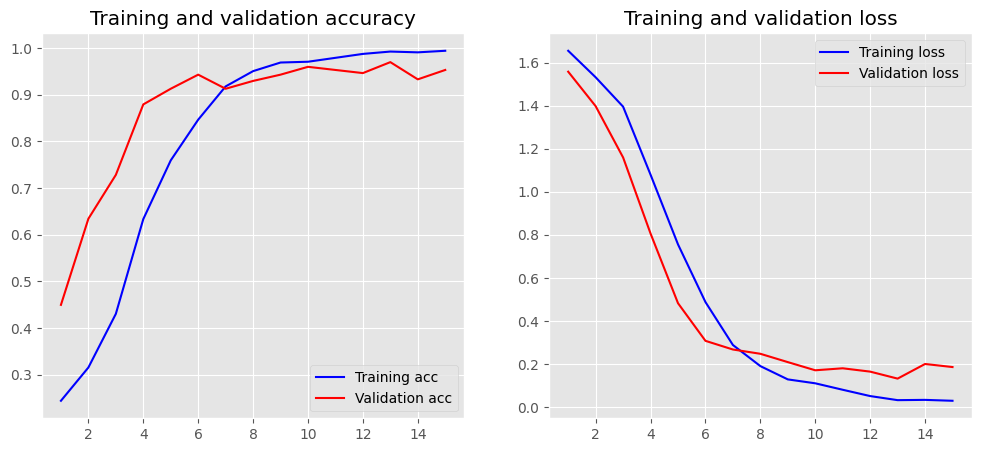

In [ ]:
# Plot history
plot_history(history)

In [ ]:
y_pred_train = glove_model.predict(padded_train, batch_size=64, verbose=1)
y_pred_bool_train = np.argmax(y_pred_train, axis=1)

print(classification_report(y_train, y_pred_bool_train, zero_division=1))

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       269
           1       1.00      1.00      1.00       209
           2       1.00      1.00      1.00       219
           3       1.00      1.00      1.00       277
           4       1.00      1.00      1.00       218

    accuracy                           1.00      1192
   macro avg       1.00      1.00      1.00      1192
weighted avg       1.00      1.00      1.00      1192



In [ ]:
y_pred_test = glove_model.predict(padded_test, batch_size=64, verbose=1)
y_pred_bool_test = np.argmax(y_pred_test, axis=1)

print(classification_report(y_test, y_pred_bool_test, zero_division=1))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        67
           1       0.98      0.92      0.95        52
           2       1.00      0.84      0.91        55
           3       0.99      0.99      0.99        69
           4       0.96      1.00      0.98        55

    accuracy                           0.95       298
   macro avg       0.96      0.95      0.95       298
weighted avg       0.96      0.95      0.95       298



#### **Obeservation:**

- with training GloVe embeddings **95%** f1-score

## 8.MLP with FastText Embeddings

#### 8.0.1 Downloading Embeddings

In [ ]:
# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz # used in gensim

!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz # used in fasttext

--2024-12-27 12:02:23--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.51, 3.163.189.96, 3.163.189.108, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G  65.6MB/s    in 28s     

2024-12-27 12:02:51 (156 MB/s) - ‘cc.en.300.bin.gz’ saved [4503593528/4503593528]



#### 8.0.2 Unzipping Embeddings

In [ ]:
!gunzip /content/cc.en.300.bin.gz

### 8.1 Embedding

In [ ]:
!pip install -q fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import fasttext
ft = fasttext.load_model('/content/cc.en.300.bin')

In [ ]:
def create_embedding_matrix(word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word in word_index:
        idx = word_index[word]
        embedding_matrix[idx] = ft.get_word_vector(word)[:embedding_dim]

    return embedding_matrix

In [ ]:
embedding_dim = 300
embedding_matrix = create_embedding_matrix(t.word_index, embedding_dim)
embedding_matrix.shape

(21533, 300)

In [ ]:
# Saving 300-D embeddings fasttext embeddings
with open(os.path.join(DATA_PATH, 'fasttext_embeddings', 'fasttext_embeddings.npy'), 'wb') as f:
    np.save(f, embedding_matrix)

In [26]:
# loading embeddings
with open(os.path.join(DATA_PATH, 'fasttext_embeddings', 'fasttext_embeddings.npy'), 'rb') as f:
    embedding_matrix = np.load(f)
embedding_dim = embedding_matrix.shape[1]
embedding_matrix.shape

(21533, 300)

### 8.2 Callbacks

In [ ]:
# Callback to save model
filepath = '/content/fasttext_model1/fasttext_model1.keras'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, mode='max', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, verbose=1)
callback = [checkpoint, reduce_lr]

### 8.3 Model Training

In [ ]:
clear_session()
input_layer = layers.Input(shape=(400,))
embed_layer = layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                              input_length=400, trainable=False)(input_layer)
maxpool1 = layers.GlobalMaxPool1D()(embed_layer)
dense1 = layers.Dense(256, activation='relu')(maxpool1)
drop1 = layers.Dropout(0.2)(dense1)
dense2 = layers.Dense(128, activation='relu')(drop1)
drop2 = layers.Dropout(0.2)(dense2)
dense3 = layers.Dense(64, activation='relu')(drop2)
output_layer = layers.Dense(5, activation='sigmoid')(dense3)
fasttext_model = Model(input_layer, output_layer)
fasttext_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 400, 300)            │       6,459,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 300)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          77,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,578,433 (25.09 MB)

 Trainable params: 118,533 (463.02 KB)

 Non-trainable params: 6,459,900 (24.64 MB)

In [ ]:
# compiling model
fasttext_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# training model
history = fasttext_model.fit(padded_train, y_train, batch_size=64, epochs=15,
                          validation_data=(padded_test, y_test), callbacks=callback)

Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2351 - loss: 1.6822
Epoch 1: val_accuracy improved from -inf to 0.22148, saving model to /content/fasttext_model1/fasttext_model1.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.2365 - loss: 1.6793 - val_accuracy: 0.2215 - val_loss: 1.5557 - learning_rate: 0.0010
Epoch 2/15
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2550 - loss: 1.5737
Epoch 2: val_accuracy improved from 0.22148 to 0.52685, saving model to /content/fasttext_model1/fasttext_model1.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.2627 - loss: 1.5687 - val_accuracy: 0.5268 - val_loss: 1.4063 - learning_rate: 0.0010
Epoch 3/15
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4275 - loss: 1.4351
Epoch 3: val_accuracy improved from 0.52685 to 0.59732, saving model to /content/fasttext_model1/fasttext_model1.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.4275 - loss: 1.4305 - val_accuracy: 0.5973 - val_loss: 1.

### 8.4 Evaluation

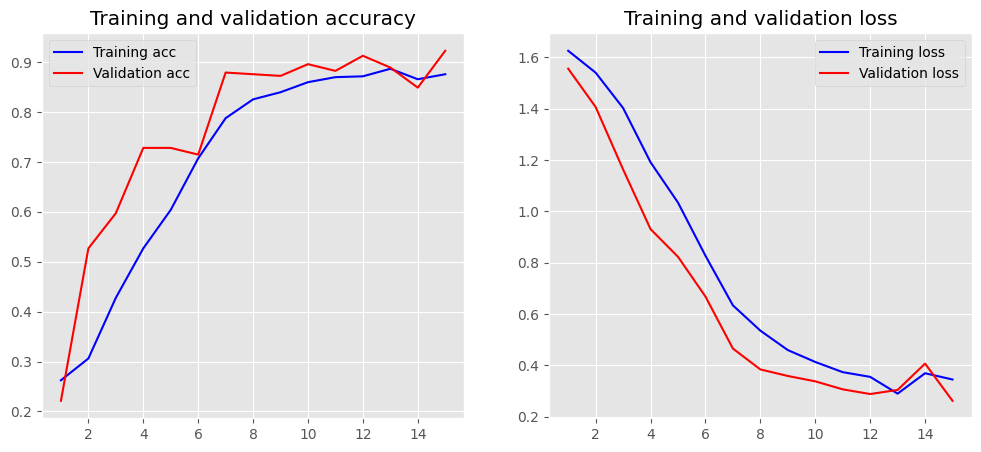

In [ ]:
# Plot history
plot_history(history)

In [ ]:
y_pred_train = fasttext_model.predict(padded_train, batch_size=64, verbose=1)
y_pred_bool_train = np.argmax(y_pred_train, axis=1)

print(classification_report(y_train, y_pred_bool_train, zero_division=1))

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       269
           1       0.89      0.96      0.92       209
           2       0.96      0.85      0.91       219
           3       0.97      0.99      0.98       277
           4       0.89      0.94      0.91       218

    accuracy                           0.93      1192
   macro avg       0.93      0.93      0.93      1192
weighted avg       0.94      0.93      0.93      1192



In [ ]:
y_pred_test = fasttext_model.predict(padded_test, batch_size=64, verbose=1)
y_pred_bool_test = np.argmax(y_pred_test, axis=1)

print(classification_report(y_test, y_pred_bool_test, zero_division=1))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
              precision    recall  f1-score   support

           0       0.89      0.93      0.91        67
           1       0.89      0.92      0.91        52
           2       0.98      0.80      0.88        55
           3       0.97      0.99      0.98        69
           4       0.90      0.96      0.93        55

    accuracy                           0.92       298
   macro avg       0.92      0.92      0.92       298
weighted avg       0.93      0.92      0.92       298



#### Observation:

- with training FastText embeddings **92%** f1-score

## 9.Training FastText Embeddings

### 9.1 Callbacks

In [22]:
# Callback to save model
filepath = '/content/fasttext_model2/fasttext_model2.keras'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, mode='max', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, verbose=1)
callback = [checkpoint, reduce_lr]

### 9.2 Model Training

In [27]:
clear_session()
input_layer = layers.Input(shape=(400,))
embed_layer = layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                              input_length=400, trainable=True)(input_layer)
maxpool1 = layers.GlobalMaxPool1D()(embed_layer)
dense1 = layers.Dense(256, activation='relu')(maxpool1)
drop1 = layers.Dropout(0.2)(dense1)
dense2 = layers.Dense(128, activation='relu')(drop1)
drop2 = layers.Dropout(0.2)(dense2)
dense3 = layers.Dense(64, activation='relu')(drop2)
output_layer = layers.Dense(5, activation='sigmoid')(dense3)
fasttext_model = Model(input_layer, output_layer)
fasttext_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 400, 300)            │       6,459,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 300)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          77,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,578,433 (25.09 MB)

 Trainable params: 6,578,433 (25.09 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# compiling model
fasttext_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
# training model
history = fasttext_model.fit(padded_train, y_train, batch_size=64, epochs=15,
                          validation_data=(padded_test, y_test), callbacks=callback)

Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.2176 - loss: 1.7139
Epoch 1: val_accuracy improved from -inf to 0.18456, saving model to /content/fasttext_model2/fasttext_model2.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 0.2186 - loss: 1.7106 - val_accuracy: 0.1846 - val_loss: 1.5890 - learning_rate: 0.0010
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.2631 - loss: 1.5764
Epoch 2: val_accuracy improved from 0.18456 to 0.44631, saving model to /content/fasttext_model2/fasttext_model2.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.2643 - loss: 1.5758 - val_accuracy: 0.4463 - val_loss: 1.4845 - learning_rate: 0.0010
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.3626 - loss: 1.4932
Epoch 3: val_accuracy improved from 0.44631 to 0.46980, saving model to /content/fasttext_model2/fasttext_model2.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.3636 - loss: 1.4917 - val_accuracy: 0.4698 - val_lo

### 9.3 Evaluation

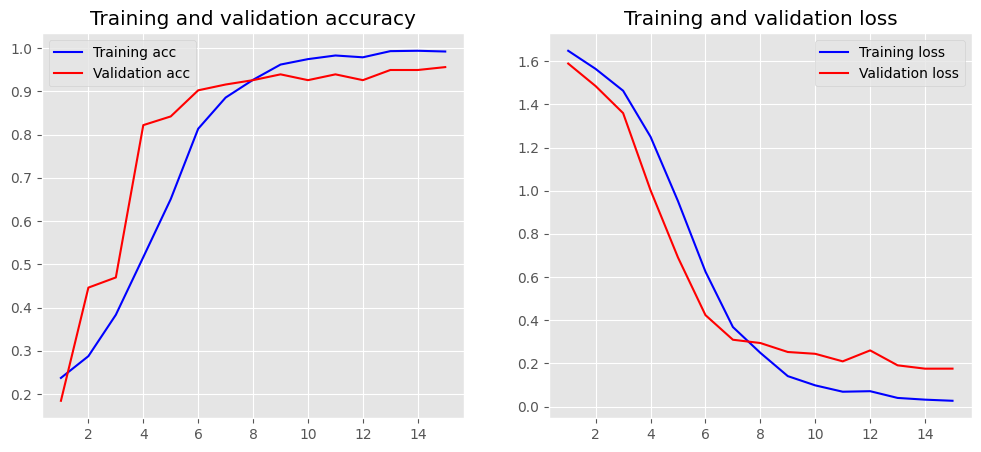

In [30]:
# Plot history
plot_history(history)

In [32]:
y_pred_train = fasttext_model.predict(padded_train, batch_size=64, verbose=1)
y_pred_bool_train = np.argmax(y_pred_train, axis=1)

print(classification_report(y_train, y_pred_bool_train, zero_division=1))

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       269
           1       1.00      1.00      1.00       209
           2       1.00      1.00      1.00       219
           3       1.00      1.00      1.00       277
           4       1.00      1.00      1.00       218

    accuracy                           1.00      1192
   macro avg       1.00      1.00      1.00      1192
weighted avg       1.00      1.00      1.00      1192



In [31]:
y_pred_test = fasttext_model.predict(padded_test, batch_size=64, verbose=1)
y_pred_bool_test = np.argmax(y_pred_test, axis=1)

print(classification_report(y_test, y_pred_bool_test, zero_division=1))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
              precision    recall  f1-score   support

           0       0.93      0.96      0.94        67
           1       0.96      0.96      0.96        52
           2       0.94      0.91      0.93        55
           3       0.97      0.99      0.98        69
           4       0.98      0.96      0.97        55

    accuracy                           0.96       298
   macro avg       0.96      0.95      0.96       298
weighted avg       0.96      0.96      0.96       298



#### **Obeservation:**

- with training FastText embeddings **96%** f1-score

## 10.LSTM

### 10.1 LSTM with 2 dense layers

### 10.1.1 Callbacks

In [ ]:
# Callback to save model
filepath = '/content/drive/MyDrive/Case_Study_2/lstm_model.keras'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, mode='max', save_best_only=True)

callback = [checkpoint]

### 10.1.2 Model Training

In [ ]:
clear_session()
input_layer = layers.Input(shape=(400,))
embed_layer = layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                              input_length=400, trainable=False)(input_layer)
lstm1 = layers.LSTM(128)(embed_layer)
drop1 = layers.Dropout(0.20)(lstm1)
dense1 = layers.Dense(128, activation='relu')(drop1)
drop2 = layers.Dropout(0.20)(dense1)
dense2 = layers.Dense(64, activation='relu')(drop2)
output_layer = layers.Dense(5, activation='sigmoid')(dense2)
lstm_model = Model(input_layer, output_layer)
lstm_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 400, 300)            │       6,459,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         219,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,704,641 (25.58 MB)

 Trainable params: 244,741 (956.02 KB)

 Non-trainable params: 6,459,900 (24.64 MB)

In [ ]:
# compiling model
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# training model
history = lstm_model.fit(padded_train, y_train, batch_size=64, epochs=10,
                        validation_data=(padded_test, y_test), callbacks=callback)

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 870ms/step - accuracy: 0.2338 - loss: 1.5951
Epoch 1: val_accuracy improved from -inf to 0.25503, saving model to /content/drive/MyDrive/Case_Study_2/lstm_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.2343 - loss: 1.5950 - val_accuracy: 0.2550 - val_loss: 1.5809
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 899ms/step - accuracy: 0.2641 - loss: 1.5554
Epoch 2: val_accuracy improved from 0.25503 to 0.26174, saving model to /content/drive/MyDrive/Case_Study_2/lstm_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 988ms/step - accuracy: 0.2646 - loss: 1.5561 - val_accuracy: 0.2617 - val_loss: 1.5788
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 895ms/step - accuracy: 0.2643 - loss: 1.5545
Epoch 3: val_accuracy did not improve from 0.26174
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.2642 - loss: 1.5545 - val_accuracy: 0.2517 - val_loss: 1.5687
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 962ms/step - accuracy: 0.3041 - loss: 1.5247
Epoch 4: v

### 10.1.3 Evaluation

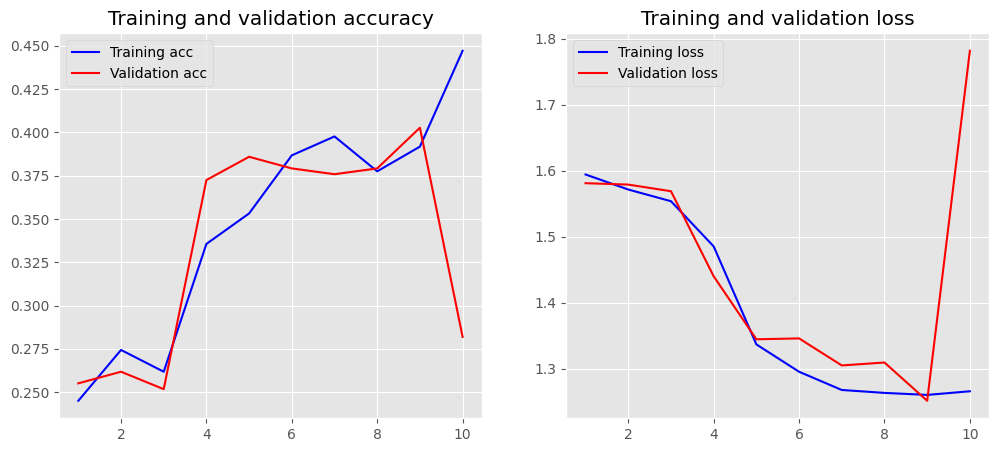

In [ ]:
plot_history(history)

In [ ]:
y_pred_train = lstm_model.predict(padded_train, batch_size=64, verbose=1)
y_pred_bool_train = np.argmax(y_pred_train, axis=1)

print(classification_report(y_train, y_pred_bool_train, zero_division=1))

19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 386ms/step
              precision    recall  f1-score   support

           0       0.25      0.99      0.41       269
           1       0.98      0.41      0.57       209
           2       0.86      0.03      0.05       219
           3       0.93      0.05      0.10       277
           4       0.23      0.04      0.06       218

    accuracy                           0.32      1192
   macro avg       0.65      0.30      0.24      1192
weighted avg       0.64      0.32      0.24      1192



In [ ]:
y_pred_test = lstm_model.predict(padded_test, batch_size=64, verbose=1)
y_pred_bool_test = np.argmax(y_pred_test, axis=1)

print(classification_report(y_test, y_pred_bool_test, zero_division=1))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
              precision    recall  f1-score   support

           0       0.24      0.97      0.38        67
           1       0.94      0.33      0.49        52
           2       0.00      0.00      0.00        55
           3       1.00      0.03      0.06        69
           4       0.00      0.00      0.00        55

    accuracy                           0.28       298
   macro avg       0.44      0.27      0.18       298
weighted avg       0.45      0.28      0.18       298



#### **Obeservation:**

- training LSTM with 2 layers **18%** f1-score

### 10.2 LSTM with no dense hidden layers

### 10.2.1 Callbacks

In [ ]:
filepath = '/content/Case_Study_2/lstm_model2.keras'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, mode='max', save_best_only=True)
callback = [checkpoint]

### 10.2.2 Model Training

In [ ]:
clear_session()
input_layer = layers.Input(shape=(400,))
embed_layer = layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                              input_length=400, trainable=False)(input_layer)
lstm1 = layers.LSTM(128)(embed_layer)
drop1 = layers.Dropout(0.20)(lstm1)
output_layer = layers.Dense(5, activation='sigmoid')(drop1)
lstm_model = Model(input_layer, output_layer)
lstm_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 400, 300)            │       6,459,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         219,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,680,193 (25.48 MB)

 Trainable params: 220,293 (860.52 KB)

 Non-trainable params: 6,459,900 (24.64 MB)

In [ ]:
# compiling model
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# training model
history = lstm_model.fit(padded_train, y_train, batch_size=64, epochs=5,
                        validation_data=(padded_test, y_test), callbacks=callback)

Epoch 1/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 902ms/step - accuracy: 0.2298 - loss: 1.5957
Epoch 1: val_accuracy improved from -inf to 0.26174, saving model to /content/Case_Study_2/lstm_model2.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.2305 - loss: 1.5953 - val_accuracy: 0.2617 - val_loss: 1.5704
Epoch 2/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3315 - loss: 1.4410
Epoch 2: val_accuracy improved from 0.26174 to 0.43289, saving model to /content/Case_Study_2/lstm_model2.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.3342 - loss: 1.4357 - val_accuracy: 0.4329 - val_loss: 1.2509
Epoch 3/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4125 - loss: 1.3958
Epoch 3: val_accuracy did not improve from 0.43289
19/19 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.4108 - loss: 1.3971 - val_accuracy: 0.2517 - val_loss: 2.4543
Epoch 4/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2536 - loss: 1.7735
Epoch 4: val_accuracy did not improve from 0.43289
1

### 10.2.3 Evaluation

In [ ]:
plot_history(history)

In [ ]:
y_pred_train = lstm_model.predict(padded_train, batch_size=64, verbose=1)
y_pred_bool_train = np.argmax(y_pred_train, axis=1)

print(classification_report(y_train, y_pred_bool_train, zero_division=1))

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 424ms/step
              precision    recall  f1-score   support

           0       0.24      1.00      0.39       269
           1       0.86      0.18      0.30       209
           2       1.00      0.04      0.07       219
           3       0.58      0.05      0.10       277
           4       1.00      0.03      0.05       218

    accuracy                           0.28      1192
   macro avg       0.74      0.26      0.18      1192
weighted avg       0.71      0.28      0.19      1192



In [ ]:
y_pred_test = lstm_model.predict(padded_test, batch_size=64, verbose=1)
y_pred_bool_test = np.argmax(y_pred_test, axis=1)

print(classification_report(y_test, y_pred_bool_test, zero_division=1))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
              precision    recall  f1-score   support

           0       0.22      0.94      0.36        67
           1       0.70      0.13      0.23        52
           2       1.00      0.00      0.00        55
           3       0.40      0.03      0.05        69
           4       1.00      0.00      0.00        55

    accuracy                           0.24       298
   macro avg       0.66      0.22      0.13       298
weighted avg       0.63      0.24      0.13       298



#### **Obeservation:**

- training LSTM with 0 layers **13%** f1-score

## 11.Bidirectional LSTM

### 11.1 Callbacks

In [ ]:
filepath = '/content/Case_Study_2/bi_lstm_model1.keras'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, mode='max', save_best_only=True)
callback = [checkpoint]

### 11.2 Model Training

In [ ]:
clear_session()
input_layer = layers.Input(shape=(400,))
embed_layer = layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                              input_length=400, trainable=False)(input_layer)
lstm1 = layers.Bidirectional(layers.LSTM(128))(embed_layer)
drop1 = layers.Dropout(0.20)(lstm1)
output_layer = layers.Dense(5, activation='sigmoid')(drop1)
bilstm_model = Model(input_layer, output_layer)
bilstm_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 400, 300)            │       6,459,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 256)                 │         439,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,900,481 (26.32 MB)

 Trainable params: 440,581 (1.68 MB)

 Non-trainable params: 6,459,900 (24.64 MB)

In [ ]:
# compiling model
bilstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# training model
history = bilstm_model.fit(padded_train, y_train, batch_size=64, epochs=10,
                        validation_data=(padded_test, y_test), callbacks=callback)

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5373 - loss: 1.3132
Epoch 1: val_accuracy improved from -inf to 0.89933, saving model to /content/Case_Study_2/bi_lstm_model1.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.5456 - loss: 1.2971 - val_accuracy: 0.8993 - val_loss: 0.3789
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9105 - loss: 0.3153
Epoch 2: val_accuracy improved from 0.89933 to 0.91946, saving model to /content/Case_Study_2/bi_lstm_model1.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.9102 - loss: 0.3154 - val_accuracy: 0.9195 - val_loss: 0.2677
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9421 - loss: 0.1864
Epoch 3: val_accuracy improved from 0.91946 to 0.94295, saving model to /content/Case_Study_2/bi_lstm_model1.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.9426 - loss: 0.1856 - val_accuracy: 0.9430 - val_loss: 0.1932
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9

### 11.3 Evaluation

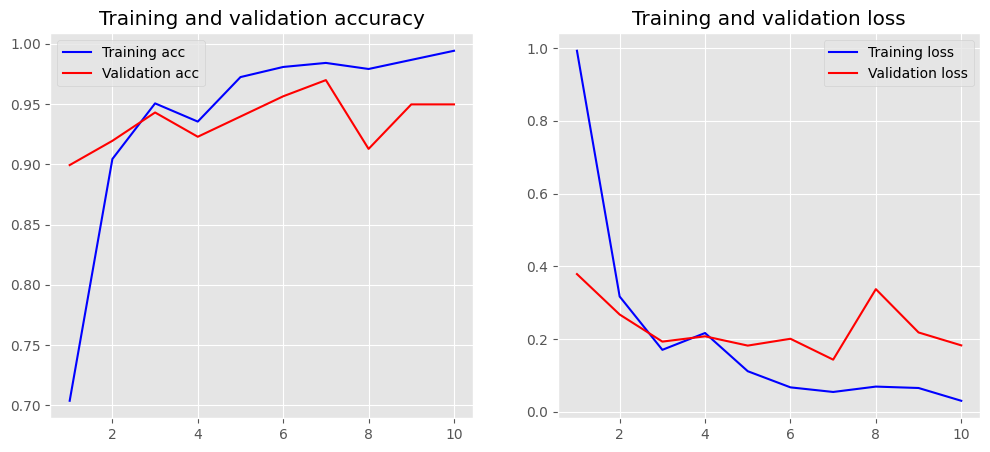

In [ ]:
plot_history(history)

In [ ]:
y_pred_train = bilstm_model.predict(padded_train, batch_size=64, verbose=1)
y_pred_bool_train = np.argmax(y_pred_train, axis=1)

print(classification_report(y_train, y_pred_bool_train, zero_division=1))

19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 773ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       269
           1       1.00      0.99      1.00       209
           2       0.99      1.00      1.00       219
           3       1.00      1.00      1.00       277
           4       1.00      1.00      1.00       218

    accuracy                           1.00      1192
   macro avg       1.00      1.00      1.00      1192
weighted avg       1.00      1.00      1.00      1192



In [ ]:
y_pred_test = bilstm_model.predict(padded_test, batch_size=64, verbose=1)
y_pred_bool_test = np.argmax(y_pred_test, axis=1)

print(classification_report(y_test, y_pred_bool_test, zero_division=1))

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 923ms/step
              precision    recall  f1-score   support

           0       0.93      0.96      0.94        67
           1       0.96      0.87      0.91        52
           2       0.96      0.93      0.94        55
           3       0.96      1.00      0.98        69
           4       0.95      0.98      0.96        55

    accuracy                           0.95       298
   macro avg       0.95      0.95      0.95       298
weighted avg       0.95      0.95      0.95       298



#### **Obeservation:**

- training BiLSTM with 1 layers **95%** f1-score

## 12.Best Model Evaluation

In [33]:
model = load_model('/content/fasttext_model2/fasttext_model2.keras')

In [39]:
# prediction on train dataset
y_pred_train = model.predict(padded_train)

# prediction on test dataset
y_pred_test = model.predict(padded_test)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [43]:
y_pred_bool_train = np.argmax(y_pred_train, axis=1)
y_pred_bool_test = np.argmax(y_pred_test, axis=1)

In [45]:
# Train Data Evaluation
print("Train Data Evaluation")
print()
print(classification_report(y_train, y_pred_bool_train))

# Train Data Evaluation
print()
print("Test Data Evaluation")
print()
print(classification_report(y_test,y_pred_bool_test))

Train Data Evaluation

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       269
           1       1.00      1.00      1.00       209
           2       1.00      1.00      1.00       219
           3       1.00      1.00      1.00       277
           4       1.00      1.00      1.00       218

    accuracy                           1.00      1192
   macro avg       1.00      1.00      1.00      1192
weighted avg       1.00      1.00      1.00      1192


Test Data Evaluation

              precision    recall  f1-score   support

           0       0.93      0.96      0.94        67
           1       0.96      0.96      0.96        52
           2       0.94      0.91      0.93        55
           3       0.97      0.99      0.98        69
           4       0.98      0.96      0.97        55

    accuracy                           0.96       298
   macro avg       0.96      0.95      0.96       298
weighted avg       0.96      0.

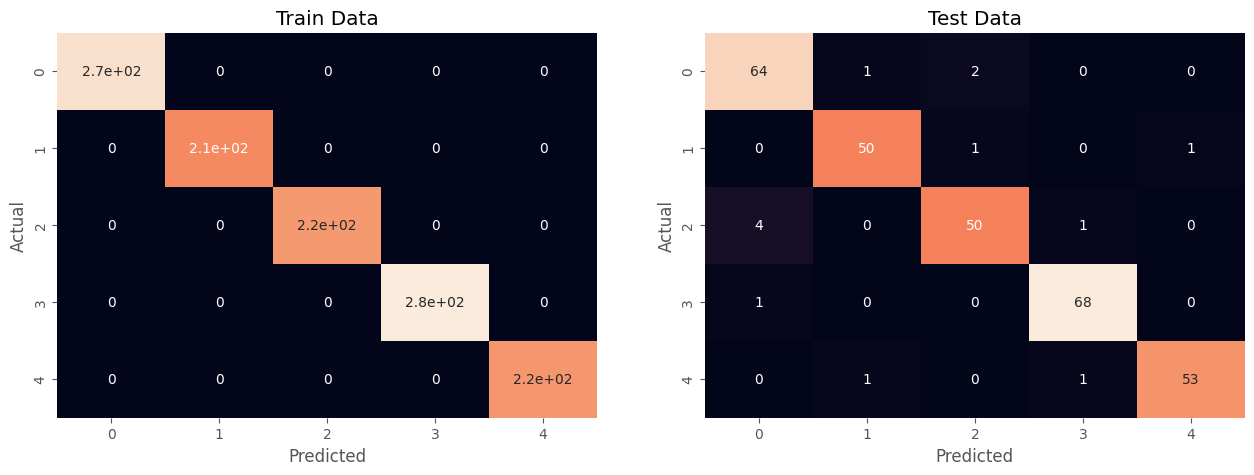

In [46]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
mat1 = confusion_matrix(y_train, y_pred_bool_train)
df_tr = pd.DataFrame(mat1, columns=np.unique(y_train), index=np.unique(y_train))
df_tr.index.name = 'Actual'
df_tr.columns.name = 'Predicted'
mat2 = confusion_matrix(y_test, y_pred_bool_test)
df_te = pd.DataFrame(mat2, columns=np.unique(y_train), index=np.unique(y_train))
df_te.index.name = 'Actual'
df_te.columns.name = 'Predicted'

plt.figure(figsize = (5, 5))
plt.subplot(1, 2, 1)
sns.heatmap(df_tr, annot=True, cbar=False)
plt.title("Train Data")
plt.subplot(1, 2, 2)
sns.heatmap(df_te, annot=True, cbar=False)
plt.title("Test Data")
plt.subplots_adjust(right=2.5)
plt.show()

## 13. Results and Conclusions

In [12]:
!pip install -q prettytable

In [13]:
from prettytable import PrettyTable

In [21]:
myTable = PrettyTable(["Model", "Embedding", "Validation Accuracy"])
myTable.add_row(["Baseline Logistic Regression", "GloVe", 0.97])
myTable.add_row(["MLP", "No Embeddings", 0.92])
myTable.add_row(["MLP", "Glove", 0.14])
myTable.add_row(["MLP", "Glove(Trained)", 0.95])
myTable.add_row(["MLP", "Fasttext", 0.92])
myTable.add_row(["MLP", "Fasttext(Trained)", 0.96])
# myTable.add_row(["CNN", "Glove", 0.7161])
myTable.add_row(["LSTM 2 Dense layers", "Fasttext", 0.18])
myTable.add_row(["LSTM", "Fasttext", 0.13])
myTable.add_row(["Bidirectional LSTM", "Glove", 0.95])
print(myTable)

+------------------------------+-------------------+---------------------+
|            Model             |     Embedding     | Validation Accuracy |
+------------------------------+-------------------+---------------------+
| Baseline Logistic Regression |       GloVe       |         0.97        |
|             MLP              |   No Embeddings   |         0.92        |
|             MLP              |       Glove       |         0.14        |
|             MLP              |   Glove(Trained)  |         0.95        |
|             MLP              |      Fasttext     |         0.92        |
|             MLP              | Fasttext(Trained) |         0.96        |
|     LSTM 2 Dense layers      |      Fasttext     |         0.18        |
|             LSTM             |      Fasttext     |         0.13        |
|      Bidirectional LSTM      |       Glove       |         0.95        |
+------------------------------+-------------------+---------------------+
